In [1]:
from pyspark.sql import SQLContext, SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as sqlF
from pyspark import SparkContext, SparkConf

In [2]:
from pyspark.ml.clustering import LDA, KMeans, BisectingKMeans, GaussianMixture
from pyspark.ml.evaluation import ClusteringEvaluator

from pyspark.ml.feature import HashingTF, IDF, RegexTokenizer, NGram
from pyspark.ml import Pipeline

from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer

from pyspark.ml.linalg import Vectors
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import MinMaxScaler, VectorAssembler

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [4]:
import findspark
findspark.init()

In [5]:
#conf = SparkConf().setAll([('spark.executor.memory', '5g'), ('spark.driver.memory','5g')])

my_spark = SparkSession \
    .builder.master('local[*]') \
    .appName("ClusterApp")\
    .getOrCreate()

#.builder.master('local[*]')\ #should use when using docker

sqlContext = SQLContext(my_spark)

In [6]:
schema = StructType([StructField("product", StringType(), True),
         StructField("votes", IntegerType(), True),
         StructField("rate", DoubleType(), True),
         StructField("text", StringType(), True)])

csv_reader = sqlContext.read.\
                options(header='false', 
                inferschema='false',
                delimiter="\t").\
                schema(schema)

In [7]:
#for i in range(17):
#    print("Reading file:",i)
#    if i<10:
#        file = "hdfs://localhost:9000/TextMining/tokens/part-0000"+str(i)
#    else:
#        file = "hdfs://localhost:9000/TextMining/tokens/part-000"+str(i)
#    df = csv_reader.csv(file)
#    if i == 0:
#        df1 = df
#    else:
#        df1 = df1.union(df)

df = csv_reader.csv("hdfs://localhost:9000/TextMining/tokens/part-*").na.drop()

In [8]:
df.count()

5467380

In [9]:
df.show(5)

+----------+-----+----+--------------------+
|   product|votes|rate|                text|
+----------+-----+----+--------------------+
|B01CT5KLIY|    1| 4.0|love idea two wom...|
|B01CT5KQMA|    1| 5.0|must veri well gr...|
|B01CT5KQMA|    1| 5.0|charact likabl pl...|
|B01CT6LRK4|    1| 4.0|abl final sit sur...|
|B01CT6LRK4|    1| 2.0|few basic tip say...|
+----------+-----+----+--------------------+
only showing top 5 rows



In [10]:
df.createTempView('data')

In [11]:
sqlContext.sql("SELECT * FROM data WHERE votes>1 ORDER BY votes DESC").show()

+----------+-----+----+--------------------+
|   product|votes|rate|                text|
+----------+-----+----+--------------------+
|B00C2WDD5I|  991| 4.0|money atlanti gen...|
|B000GFK7L6|  986| 4.0|updat novemb orig...|
|B00C2WDD5I|  970| 1.0|honest onli thing...|
|B003ICWE92|  908| 1.0|ann green gabl se...|
|B00SRY5F8I|  904| 5.0|not rememb buy ap...|
|B00EOARZ4G|  842| 5.0|first reader revi...|
|B006PJ3UKC|  798| 5.0|noth good thing s...|
|B00DMCV7K0|  797| 1.0|soon start read n...|
|B00D01TYQ2|  784| 1.0|no way affili new...|
|B00WCD5GYS|  770| 5.0|reread first time...|
|B004KZPK6K|  770| 5.0|money war peac le...|
|B004KKY782|  763| 1.0|well base star en...|
|B006PJ3UKC|  751| 5.0|app beauti well d...|
|B017X1K7X8|  748| 4.0|hello soon gre te...|
|B00YN6XHMU|  747| 1.0|new doorstopp el ...|
|B00XSSYR50|  745| 5.0|sometim not go fi...|
|B00R7HDLAU|  721| 1.0|major spoiler con...|
|B0142IHZPI|  713| 4.0|first thought ver...|
|B000FDJ0FS|  696| 1.0|realli nice wsj d...|
|B00C2WDD5

In [12]:
sqlContext.sql("SELECT * FROM data WHERE votes>1").count()

730890

# Preprocessing

In [13]:
tokenizer = RegexTokenizer(inputCol="text", outputCol="words", pattern="\\W")
ngram = NGram(n=1, inputCol="words", outputCol="n-gram")
tf = HashingTF(inputCol="n-gram", outputCol="tf")
idf = IDF(inputCol="tf", outputCol="features", minDocFreq=3)

pipeline = Pipeline(stages=[tokenizer, ngram, tf,idf])

In [14]:
mod1 = pipeline.fit(df)

In [15]:
df2 = mod1.transform(df)

In [16]:
df2.select('words','tf','features').show()

+--------------------+--------------------+--------------------+
|               words|                  tf|            features|
+--------------------+--------------------+--------------------+
|[love, idea, two,...|(262144,[30289,30...|(262144,[30289,30...|
|[must, veri, well...|(262144,[54961,77...|(262144,[54961,77...|
|[charact, likabl,...|(262144,[10920,16...|(262144,[10920,16...|
|[abl, final, sit,...|(262144,[36319,56...|(262144,[36319,56...|
|[few, basic, tip,...|(262144,[12472,82...|(262144,[12472,82...|
|[best, world, suc...|(262144,[60080,16...|(262144,[60080,16...|
|[complet, guid, s...|(262144,[43379,80...|(262144,[43379,80...|
|[again, veri, ent...|(262144,[45843,86...|(262144,[45843,86...|
|[great, social, s...|(262144,[71895,26...|(262144,[71895,26...|
|[wonder, tip, mus...|(262144,[82032,13...|(262144,[82032,13...|
|       [nice, pleas]|(262144,[22346,16...|(262144,[22346,16...|
|[well, connect, a...|(262144,[71895,72...|(262144,[71895,72...|
|[great, new, styl...|(26

# Cluster k-means

In [15]:
evaluator = ClusteringEvaluator()
sil_res = []
for k in range(2,7):
    clus = KMeans().setK(k)
    mod3 = clus.fit(df2)
    df3 = mod3.transform(df2)
    silhouette = evaluator.evaluate(df3)
    sil_res.append(silhouette)
    print("For k =",k,"Silhouette = " + str(silhouette))

For k= 2 Silhouette = 0.7823365398533508
For k= 3 Silhouette = 0.7870275788558053
For k= 4 Silhouette = 0.7176003947437463
For k= 5 Silhouette = 0.6232596807330575
For k= 6 Silhouette = 0.5677034840644087
For k= 7 Silhouette = 0.6326736648530189


Py4JJavaError: An error occurred while calling o649.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 49 in stage 416.0 failed 1 times, most recent failure: Lost task 49.0 in stage 416.0 (TID 51149, 192.168.1.222, executor driver): java.lang.OutOfMemoryError: Java heap space
	at java.lang.reflect.Array.newInstance(Array.java:75)
	at java.io.ObjectInputStream.readArray(ObjectInputStream.java:1883)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1529)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2231)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2155)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2013)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1535)
	at java.io.ObjectInputStream.readArray(ObjectInputStream.java:1919)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1529)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2231)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2155)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2013)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1535)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2231)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2155)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2013)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1535)
	at java.io.ObjectInputStream.readArray(ObjectInputStream.java:1919)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1529)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2231)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2155)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2013)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1535)
	at java.io.ObjectInputStream.readArray(ObjectInputStream.java:1919)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1529)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2231)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2155)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2013)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1535)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2231)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2155)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2013)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:1989)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:1977)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:1976)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1976)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:956)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:956)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:956)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2206)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2155)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2144)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:758)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2116)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2137)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2156)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2181)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1004)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:388)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1003)
	at org.apache.spark.sql.execution.SparkPlan.executeCollect(SparkPlan.scala:365)
	at org.apache.spark.sql.Dataset.collectFromPlan(Dataset.scala:3482)
	at org.apache.spark.sql.Dataset.$anonfun$collect$1(Dataset.scala:2812)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:3472)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$4(SQLExecution.scala:100)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:160)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:87)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3468)
	at org.apache.spark.sql.Dataset.collect(Dataset.scala:2812)
	at org.apache.spark.ml.clustering.ClusteringSummary.clusterSizes$lzycompute(ClusteringSummary.scala:49)
	at org.apache.spark.ml.clustering.ClusteringSummary.clusterSizes(ClusteringSummary.scala:47)
	at org.apache.spark.ml.clustering.KMeans.$anonfun$fit$1(KMeans.scala:376)
	at org.apache.spark.ml.util.Instrumentation$.$anonfun$instrumented$1(Instrumentation.scala:191)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:191)
	at org.apache.spark.ml.clustering.KMeans.fit(KMeans.scala:334)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:745)
Caused by: java.lang.OutOfMemoryError: Java heap space
	at java.lang.reflect.Array.newInstance(Array.java:75)
	at java.io.ObjectInputStream.readArray(ObjectInputStream.java:1883)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1529)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2231)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2155)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2013)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1535)
	at java.io.ObjectInputStream.readArray(ObjectInputStream.java:1919)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1529)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2231)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2155)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2013)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1535)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2231)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2155)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2013)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1535)
	at java.io.ObjectInputStream.readArray(ObjectInputStream.java:1919)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1529)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2231)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2155)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2013)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1535)
	at java.io.ObjectInputStream.readArray(ObjectInputStream.java:1919)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1529)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2231)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2155)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2013)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1535)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2231)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2155)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2013)


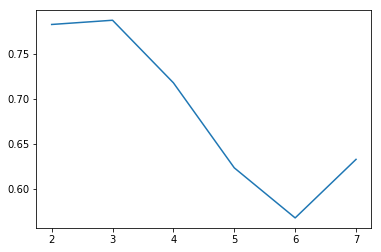

In [21]:
sns.lineplot(list(range(2,8)),sil_res)
plt.show()

In [17]:
#3 is the best
evaluator = ClusteringEvaluator()
clus = KMeans().setK(3)
cluster_model = clus.fit(df2)
#silhouette = evaluator.evaluate(df4)

In [18]:
df3 = cluster_model.transform(df2)

In [19]:
df3.show(3)

+----------+-----+----+--------------------+--------------------+--------------------+--------------------+----------+
|   product|votes|rate|                text|               words|         rawFeatures|            features|prediction|
+----------+-----+----+--------------------+--------------------+--------------------+--------------------+----------+
|B01CT5KLIY|    1| 4.0|love idea two wom...|[love, idea, two,...|(262144,[0,1,2,6,...|(262144,[0,1,2,6,...|         0|
|B01CT5KQMA|    1| 5.0|must veri well gr...|[must, veri, well...|(262144,[0,1,7,8,...|(262144,[0,1,7,8,...|         0|
|B01CT5KQMA|    1| 5.0|charact likabl pl...|[charact, likabl,...|(262144,[0,5,8,15...|(262144,[0,5,8,15...|         0|
+----------+-----+----+--------------------+--------------------+--------------------+--------------------+----------+
only showing top 3 rows



In [26]:
df3.select('product','votes','rate','text','prediction').show()

+----------+-----+----+--------------------+----------+
|   product|votes|rate|                text|prediction|
+----------+-----+----+--------------------+----------+
|B01CT5KLIY|    1| 4.0|love idea two wom...|         0|
|B01CT5KQMA|    1| 5.0|must veri well gr...|         0|
|B01CT5KQMA|    1| 5.0|charact likabl pl...|         0|
|B01CT6LRK4|    1| 4.0|abl final sit sur...|         0|
|B01CT6LRK4|    1| 2.0|few basic tip say...|         0|
|B01CT6LRK4|    1| 5.0| best world success |         0|
|B01CT6LRK4|    1| 5.0|complet guid succ...|         0|
|B01CT6LRK4|    1| 5.0|again veri entert...|         0|
|B01CT6LRK4|    1| 5.0|great social succ...|         0|
|B01CT6LRK4|    1| 5.0|wonder tip must e...|         0|
|B01CT6LRK4|    1| 5.0|         nice pleas |         0|
|B01CT6LRK4|    1| 5.0|well connect aspe...|         0|
|B01CT6LRK4|    1| 4.0|great new style w...|         0|
|B01CT6LRK4|    1| 4.0|          veri good |         0|
|B01CT6LRK4|    1| 5.0|guid develop pers...|    

In [27]:
df3.select('product','votes','rate','text','prediction').write.mode('overwrite').options(header='true').csv('hdfs://localhost:9000/TextMining/tokens/clustered')

In [28]:
res = df3.select("rate","prediction").toPandas()

In [29]:
res.prediction.value_counts()

0    5035048
2     425153
1       7179
Name: prediction, dtype: int64

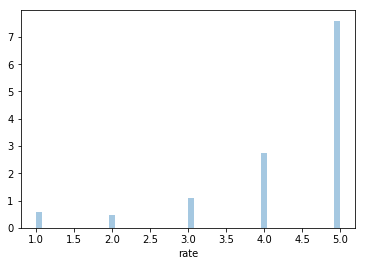

In [34]:
sns.distplot(res.rate, norm_hist=True, kde=False)

In [38]:
assembler = VectorAssembler(inputCols=['votes','rate','prediction'], outputCol="corr_features")
corr_df = assembler.transform(df3)
pearsonCorr = Correlation.corr(corr_df, 'corr_features', 'pearson').collect()

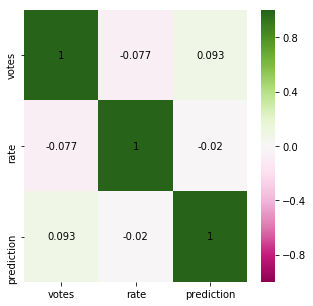

In [47]:
plt.figure(figsize=(5, 5))
sns.heatmap(pearsonCorr[0][0].values.reshape(3,3), 
            vmax=1, vmin=-1, annot=True,annot_kws={'color':'black'},
            xticklabels=['votes','rate','cluster'], 
            yticklabels=['votes','rate','cluster'], 
            center=0, cmap="PiYG")
plt.show()

In [53]:
df3.select(['rate','prediction']).groupBy('prediction').mean().show()

+----------+------------------+---------------+
|prediction|         avg(rate)|avg(prediction)|
+----------+------------------+---------------+
|         1|3.9931745368435716|            1.0|
|         2|  4.22976199156539|            2.0|
|         0| 4.307239176270017|            0.0|
+----------+------------------+---------------+



# Sentiment with TextBlob

In [17]:
df = csv_reader.csv("hdfs://localhost:9000/TextMining/cleaned_data/part-*").na.drop()

In [18]:
df.show()

+----------+-----+----+--------------------+
|   product|votes|rate|                text|
+----------+-----+----+--------------------+
|0143065971|    1| 5.0|Great condition a...|
|0143065971|    4| 5.0|This is a masterp...|
|1423600150|    1| 5.0|Great little cook...|
|1423600150|    1| 5.0|   Great mexi stuff.|
|1423600150|    1| 5.0|          Great book|
|1423600150|    1| 5.0|Excellent book on...|
|1423600150|    1| 3.0|It is rather disa...|
|1423600150|    1| 5.0|Some unique and d...|
|1423600150|    1| 5.0|Excellent book ri...|
|1423600150|    1| 5.0|Going to a favori...|
|1423600150|   16| 5.0|Many people are s...|
|1423600150|    4| 3.0|I admire the SF S...|
|1423600150|    1| 5.0|This book has goo...|
|1423600150|    1| 4.0|If you like makin...|
|1423600150|    4| 5.0|great little book...|
|1423600150|    1| 4.0|The Mailman seeme...|
|1423600150|    1| 5.0|I usually make up...|
|1423600150|    1| 1.0|No color photos. ...|
|1423600150|    1| 5.0|VERY GOOD READING...|
|142360015

In [21]:
df.printSchema()

<bound method DataFrame.printSchema of DataFrame[product: string, votes: int, rate: double, text: string]>

In [19]:
from textblob import TextBlob

def sentiment_analysis(text):
    return TextBlob(text).sentiment.polarity

sentiment_udf = sqlF.udf(sentiment_analysis , FloatType())

In [24]:
df = df.withColumn("sentiment_score", sentiment_udf(df['text']))

In [26]:
df.show()

+----------+-----+----+--------------------+---------------+
|   product|votes|rate|                text|sentiment_score|
+----------+-----+----+--------------------+---------------+
|0143065971|    1| 5.0|Great condition a...|            0.9|
|0143065971|    4| 5.0|This is a masterp...|     0.11708705|
|1423600150|    1| 5.0|Great little cook...|       0.340625|
|1423600150|    1| 5.0|   Great mexi stuff.|            0.8|
|1423600150|    1| 5.0|          Great book|            0.8|
|1423600150|    1| 5.0|Excellent book on...|           0.65|
|1423600150|    1| 3.0|It is rather disa...|    0.036666665|
|1423600150|    1| 5.0|Some unique and d...|         0.6875|
|1423600150|    1| 5.0|Excellent book ri...|     0.64285713|
|1423600150|    1| 5.0|Going to a favori...|            0.5|
|1423600150|   16| 5.0|Many people are s...|     0.27673653|
|1423600150|    4| 3.0|I admire the SF S...|          -0.75|
|1423600150|    1| 5.0|This book has goo...|     0.56666666|
|1423600150|    1| 4.0|I

In [28]:
assembler = VectorAssembler(inputCols=['votes','rate','sentiment_score'], outputCol="corr_features")

corr_df = assembler.transform(df)
pearsonCorr = Correlation.corr(corr_df, 'corr_features', 'pearson').collect()

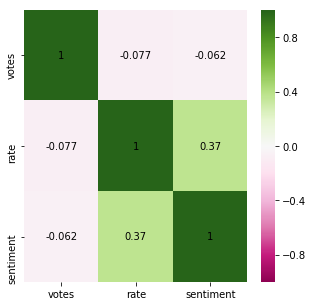

In [29]:
plt.figure(figsize=(5, 5))
sns.heatmap(pearsonCorr[0][0].values.reshape(3,3), 
            vmax=1, vmin=-1, annot=True,annot_kws={'color':'black'},
            xticklabels=['votes','rate','sentiment'], 
            yticklabels=['votes','rate','sentiment'], 
            center=0, cmap="PiYG")
plt.show()

In [35]:
df.select('votes','rate','sentiment_score').groupBy('rate').mean('votes','sentiment_score').show()

+----+------------------+--------------------+
|rate|        avg(votes)|avg(sentiment_score)|
+----+------------------+--------------------+
| 1.0|3.3596850028055645|-0.01607412162580...|
| 4.0|1.4177290404419742|  0.2772317332324222|
| 3.0|1.7377818403412553| 0.18949055701067982|
| 2.0|2.5251020121007457| 0.07714642109464315|
| 5.0|1.5615217834308246| 0.33499123732359426|
+----+------------------+--------------------+



In [ ]:
df.t